# Part 1: Basic Data Manipulation & Simple Recommendation



## 1.Read in the rating file and create an RDD consisting of parsed lines, then count the number of ratings.

In [4]:
from pyspark import SparkContext

# Create a Spark session
sc = SparkContext .getOrCreate()

ratings_rdd = sc.textFile("dataset/ratings.csv")
header = ratings_rdd.first()

# Remove the header and then parse each line
ratings_rdd = ratings_rdd.filter(lambda line: line != header) \
    .map(lambda line: line.split(',')) \
    .map(lambda tokens: (tokens[0], tokens[1], float(tokens[2]), tokens[3]))

num_ratings = ratings_rdd.count()
print(num_ratings)

25000095


## 2. Recommend 5 movies with the highest average rating.

In [2]:
from pyspark.sql import SparkSession

spark = SparkSession.builder.appName("MovieLens").config("spark.driver.memory", "8G").getOrCreate()
ratings_df = spark.createDataFrame(ratings_rdd, ["userId", "movieId", "rating", "timestamp"])

#  Count the number of ratings
avg_ratings_df = ratings_df.groupBy("movieId").avg("rating")

# Recommend 5 movies with the highest average rating
top_movies = avg_ratings_df.orderBy("avg(rating)", ascending=False).limit(5)

top_movies.show()

+-------+-----------+
|movieId|avg(rating)|
+-------+-----------+
| 195549|        5.0|
| 169820|        5.0|
| 182345|        5.0|
| 137964|        5.0|
| 159048|        5.0|
+-------+-----------+



## 3. Other operations to enrich your data analysis.

## 4. Try to create visualizations to convey the insights.

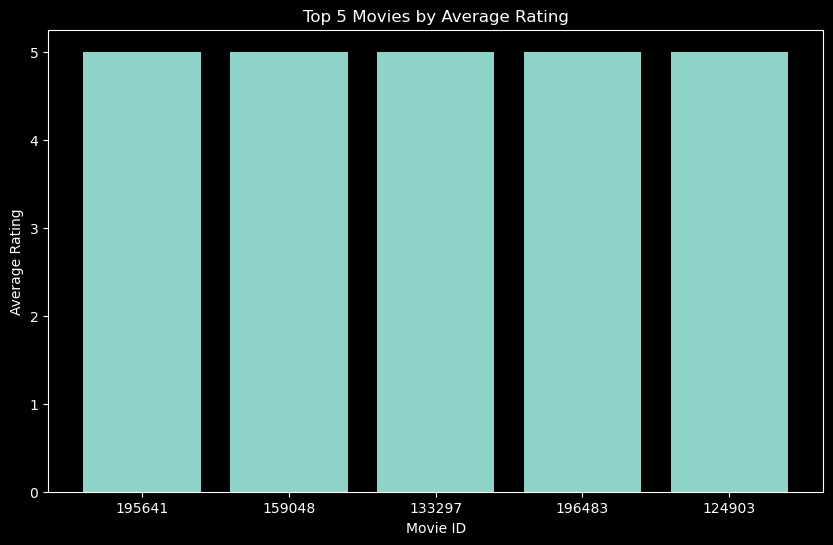

In [3]:
import matplotlib.pyplot as plt

# Retrieve the data in the form of a Pandas DataFrame
top_movies_pd = top_movies.toPandas()

# Create a visualization
plt.figure(figsize=(10, 6))
plt.bar(top_movies_pd['movieId'], top_movies_pd['avg(rating)'])
plt.xlabel('Movie ID')
plt.ylabel('Average Rating')
plt.title('Top 5 Movies by Average Rating')
plt.show()


# Part2: Rating Prediction

## 1. First split rating data into 70% training set and 30% testing set.

In [3]:
from pyspark.sql import Row

ratings_ml = ratings_df.rdd.map(lambda r: Row(userId=int(r[0]), movieId=int(r[1]), rating=float(r[2])))
ratings_ml_df = spark.createDataFrame(ratings_ml)

# Split the dataset
(training, test) = ratings_ml_df.randomSplit([0.7, 0.3])

23/11/23 08:54:35 WARN PythonRunner: Detected deadlock while completing task 0.0 in stage 6 (TID 52): Attempting to kill Python Worker


## 2. Choose one matrix factorization algorithm to predict the rating score based on the rating data file only.

In [5]:
from pyspark.ml.evaluation import RegressionEvaluator
from pyspark.ml.recommendation import ALS


# Create ALS model
als = ALS(userCol="userId", itemCol="movieId", ratingCol="rating", coldStartStrategy="drop", nonnegative=True)

# Define a grid of parameters to search
param_grid = {
    "rank": [10, 20, 30],
    "maxIter": [5, 10, 20],
    "regParam": [0.01, 0.1, 1.0]
}

# Initialize evaluator
evaluator = RegressionEvaluator(metricName="rmse", labelCol="rating", predictionCol="prediction")

best_model = None
best_error = float('inf')
best_params = None

# Grid search through parameters
for rank in param_grid["rank"]:
    for max_iter in param_grid["maxIter"]:
        for reg_param in param_grid["regParam"]:
            als.setParams(rank=rank, maxIter=max_iter, regParam=reg_param)
            
            # Fit ALS model on training data
            model = als.fit(training)
            
            # Evaluate on test data
            predictions = model.transform(test)
            error = evaluator.evaluate(predictions)
            
            # Update best parameters if current model is better
            if error < best_error:
                best_error = error
                best_model = model
                best_params = {"rank": rank, "maxIter": max_iter, "regParam": reg_param}

# Output the best parameters and error
print("Best Parameters:", best_params)
print("Best RMSE:", best_error)

# Make predictions using the best model
test_predictions = best_model.transform(test)

# Generate top 3 recommendations for all users using the best model
recommendations = best_model.recommendForAllUsers(3)
recommendations.show(truncate=False)

23/11/23 05:14:00 WARN BlockManager: Block rdd_49_0 could not be removed as it was not found on disk or in memory
23/11/23 05:14:00 WARN BlockManager: Block rdd_50_0 could not be removed as it was not found on disk or in memory
23/11/23 05:14:00 ERROR Executor: Exception in task 0.0 in stage 16.0 (TID 156)
java.lang.OutOfMemoryError: Java heap space
	at java.util.Arrays.copyOf(Arrays.java:3284)
	at scala.collection.mutable.ArrayBuilder$ofInt.mkArray(ArrayBuilder.scala:339)
	at scala.collection.mutable.ArrayBuilder$ofInt.result(ArrayBuilder.scala:383)
	at scala.collection.mutable.ArrayBuilder$ofInt.result(ArrayBuilder.scala:330)
	at org.apache.spark.ml.recommendation.ALS$UncompressedInBlockBuilder.build(ALS.scala:1452)
	at org.apache.spark.ml.recommendation.ALS$.$anonfun$makeBlocks$5(ALS.scala:1660)
	at org.apache.spark.ml.recommendation.ALS$$$Lambda$3655/451741565.apply(Unknown Source)
	at org.apache.spark.rdd.PairRDDFunctions.$anonfun$mapValues$3(PairRDDFunctions.scala:752)
	at org.ap

Py4JJavaError: An error occurred while calling o127.fit.
: org.apache.spark.SparkException: Job aborted due to stage failure: Task 0 in stage 16.0 failed 1 times, most recent failure: Lost task 0.0 in stage 16.0 (TID 156) (192.168.102.123 executor driver): java.lang.OutOfMemoryError: Java heap space
	at java.util.Arrays.copyOf(Arrays.java:3284)
	at scala.collection.mutable.ArrayBuilder$ofInt.mkArray(ArrayBuilder.scala:339)
	at scala.collection.mutable.ArrayBuilder$ofInt.result(ArrayBuilder.scala:383)
	at scala.collection.mutable.ArrayBuilder$ofInt.result(ArrayBuilder.scala:330)
	at org.apache.spark.ml.recommendation.ALS$UncompressedInBlockBuilder.build(ALS.scala:1452)
	at org.apache.spark.ml.recommendation.ALS$.$anonfun$makeBlocks$5(ALS.scala:1660)
	at org.apache.spark.ml.recommendation.ALS$$$Lambda$3655/451741565.apply(Unknown Source)
	at org.apache.spark.rdd.PairRDDFunctions.$anonfun$mapValues$3(PairRDDFunctions.scala:752)
	at org.apache.spark.rdd.PairRDDFunctions$$Lambda$3636/1159170700.apply(Unknown Source)
	at scala.collection.Iterator$$anon$10.next(Iterator.scala:461)
	at org.apache.spark.storage.memory.MemoryStore.putIterator(MemoryStore.scala:224)
	at org.apache.spark.storage.memory.MemoryStore.putIteratorAsValues(MemoryStore.scala:302)
	at org.apache.spark.storage.BlockManager.$anonfun$doPutIterator$1(BlockManager.scala:1535)
	at org.apache.spark.storage.BlockManager$$Lambda$911/1756540820.apply(Unknown Source)
	at org.apache.spark.storage.BlockManager.org$apache$spark$storage$BlockManager$$doPut(BlockManager.scala:1462)
	at org.apache.spark.storage.BlockManager.doPutIterator(BlockManager.scala:1526)
	at org.apache.spark.storage.BlockManager.getOrElseUpdate(BlockManager.scala:1349)
	at org.apache.spark.rdd.RDD.getOrCompute(RDD.scala:375)
	at org.apache.spark.rdd.RDD.iterator(RDD.scala:326)
	at org.apache.spark.rdd.MapPartitionsRDD.compute(MapPartitionsRDD.scala:52)
	at org.apache.spark.rdd.RDD.computeOrReadCheckpoint(RDD.scala:364)
	at org.apache.spark.rdd.RDD.$anonfun$getOrCompute$1(RDD.scala:377)
	at org.apache.spark.rdd.RDD$$Lambda$3591/389148629.apply(Unknown Source)
	at org.apache.spark.storage.BlockManager.$anonfun$doPutIterator$1(BlockManager.scala:1535)
	at org.apache.spark.storage.BlockManager$$Lambda$911/1756540820.apply(Unknown Source)
	at org.apache.spark.storage.BlockManager.org$apache$spark$storage$BlockManager$$doPut(BlockManager.scala:1462)
	at org.apache.spark.storage.BlockManager.doPutIterator(BlockManager.scala:1526)
	at org.apache.spark.storage.BlockManager.getOrElseUpdate(BlockManager.scala:1349)
	at org.apache.spark.rdd.RDD.getOrCompute(RDD.scala:375)
	at org.apache.spark.rdd.RDD.iterator(RDD.scala:326)
	at org.apache.spark.scheduler.ResultTask.runTask(ResultTask.scala:92)
	at org.apache.spark.TaskContext.runTaskWithListeners(TaskContext.scala:161)

Driver stacktrace:
	at org.apache.spark.scheduler.DAGScheduler.failJobAndIndependentStages(DAGScheduler.scala:2785)
	at org.apache.spark.scheduler.DAGScheduler.$anonfun$abortStage$2(DAGScheduler.scala:2721)
	at org.apache.spark.scheduler.DAGScheduler.$anonfun$abortStage$2$adapted(DAGScheduler.scala:2720)
	at scala.collection.mutable.ResizableArray.foreach(ResizableArray.scala:62)
	at scala.collection.mutable.ResizableArray.foreach$(ResizableArray.scala:55)
	at scala.collection.mutable.ArrayBuffer.foreach(ArrayBuffer.scala:49)
	at org.apache.spark.scheduler.DAGScheduler.abortStage(DAGScheduler.scala:2720)
	at org.apache.spark.scheduler.DAGScheduler.$anonfun$handleTaskSetFailed$1(DAGScheduler.scala:1206)
	at org.apache.spark.scheduler.DAGScheduler.$anonfun$handleTaskSetFailed$1$adapted(DAGScheduler.scala:1206)
	at scala.Option.foreach(Option.scala:407)
	at org.apache.spark.scheduler.DAGScheduler.handleTaskSetFailed(DAGScheduler.scala:1206)
	at org.apache.spark.scheduler.DAGSchedulerEventProcessLoop.doOnReceive(DAGScheduler.scala:2984)
	at org.apache.spark.scheduler.DAGSchedulerEventProcessLoop.onReceive(DAGScheduler.scala:2923)
	at org.apache.spark.scheduler.DAGSchedulerEventProcessLoop.onReceive(DAGScheduler.scala:2912)
	at org.apache.spark.util.EventLoop$$anon$1.run(EventLoop.scala:49)
	at org.apache.spark.scheduler.DAGScheduler.runJob(DAGScheduler.scala:971)
	at org.apache.spark.SparkContext.runJob(SparkContext.scala:2263)
	at org.apache.spark.SparkContext.runJob(SparkContext.scala:2284)
	at org.apache.spark.SparkContext.runJob(SparkContext.scala:2303)
	at org.apache.spark.SparkContext.runJob(SparkContext.scala:2328)
	at org.apache.spark.rdd.RDD.count(RDD.scala:1266)
	at org.apache.spark.ml.recommendation.ALS$.train(ALS.scala:995)
	at org.apache.spark.ml.recommendation.ALS.$anonfun$fit$1(ALS.scala:737)
	at org.apache.spark.ml.util.Instrumentation$.$anonfun$instrumented$1(Instrumentation.scala:191)
	at scala.util.Try$.apply(Try.scala:213)
	at org.apache.spark.ml.util.Instrumentation$.instrumented(Instrumentation.scala:191)
	at org.apache.spark.ml.recommendation.ALS.fit(ALS.scala:714)
	at org.apache.spark.ml.recommendation.ALS.fit(ALS.scala:616)
	at sun.reflect.NativeMethodAccessorImpl.invoke0(Native Method)
	at sun.reflect.NativeMethodAccessorImpl.invoke(NativeMethodAccessorImpl.java:62)
	at sun.reflect.DelegatingMethodAccessorImpl.invoke(DelegatingMethodAccessorImpl.java:43)
	at java.lang.reflect.Method.invoke(Method.java:498)
	at py4j.reflection.MethodInvoker.invoke(MethodInvoker.java:244)
	at py4j.reflection.ReflectionEngine.invoke(ReflectionEngine.java:374)
	at py4j.Gateway.invoke(Gateway.java:282)
	at py4j.commands.AbstractCommand.invokeMethod(AbstractCommand.java:132)
	at py4j.commands.CallCommand.execute(CallCommand.java:79)
	at py4j.ClientServerConnection.waitForCommands(ClientServerConnection.java:182)
	at py4j.ClientServerConnection.run(ClientServerConnection.java:106)
	at java.lang.Thread.run(Thread.java:750)
Caused by: java.lang.OutOfMemoryError: Java heap space
	at java.util.Arrays.copyOf(Arrays.java:3284)
	at scala.collection.mutable.ArrayBuilder$ofInt.mkArray(ArrayBuilder.scala:339)
	at scala.collection.mutable.ArrayBuilder$ofInt.result(ArrayBuilder.scala:383)
	at scala.collection.mutable.ArrayBuilder$ofInt.result(ArrayBuilder.scala:330)
	at org.apache.spark.ml.recommendation.ALS$UncompressedInBlockBuilder.build(ALS.scala:1452)
	at org.apache.spark.ml.recommendation.ALS$.$anonfun$makeBlocks$5(ALS.scala:1660)
	at org.apache.spark.ml.recommendation.ALS$$$Lambda$3655/451741565.apply(Unknown Source)
	at org.apache.spark.rdd.PairRDDFunctions.$anonfun$mapValues$3(PairRDDFunctions.scala:752)
	at org.apache.spark.rdd.PairRDDFunctions$$Lambda$3636/1159170700.apply(Unknown Source)
	at scala.collection.Iterator$$anon$10.next(Iterator.scala:461)
	at org.apache.spark.storage.memory.MemoryStore.putIterator(MemoryStore.scala:224)
	at org.apache.spark.storage.memory.MemoryStore.putIteratorAsValues(MemoryStore.scala:302)
	at org.apache.spark.storage.BlockManager.$anonfun$doPutIterator$1(BlockManager.scala:1535)
	at org.apache.spark.storage.BlockManager$$Lambda$911/1756540820.apply(Unknown Source)
	at org.apache.spark.storage.BlockManager.org$apache$spark$storage$BlockManager$$doPut(BlockManager.scala:1462)
	at org.apache.spark.storage.BlockManager.doPutIterator(BlockManager.scala:1526)
	at org.apache.spark.storage.BlockManager.getOrElseUpdate(BlockManager.scala:1349)
	at org.apache.spark.rdd.RDD.getOrCompute(RDD.scala:375)
	at org.apache.spark.rdd.RDD.iterator(RDD.scala:326)
	at org.apache.spark.rdd.MapPartitionsRDD.compute(MapPartitionsRDD.scala:52)
	at org.apache.spark.rdd.RDD.computeOrReadCheckpoint(RDD.scala:364)
	at org.apache.spark.rdd.RDD.$anonfun$getOrCompute$1(RDD.scala:377)
	at org.apache.spark.rdd.RDD$$Lambda$3591/389148629.apply(Unknown Source)
	at org.apache.spark.storage.BlockManager.$anonfun$doPutIterator$1(BlockManager.scala:1535)
	at org.apache.spark.storage.BlockManager$$Lambda$911/1756540820.apply(Unknown Source)
	at org.apache.spark.storage.BlockManager.org$apache$spark$storage$BlockManager$$doPut(BlockManager.scala:1462)
	at org.apache.spark.storage.BlockManager.doPutIterator(BlockManager.scala:1526)
	at org.apache.spark.storage.BlockManager.getOrElseUpdate(BlockManager.scala:1349)
	at org.apache.spark.rdd.RDD.getOrCompute(RDD.scala:375)
	at org.apache.spark.rdd.RDD.iterator(RDD.scala:326)
	at org.apache.spark.scheduler.ResultTask.runTask(ResultTask.scala:92)
	at org.apache.spark.TaskContext.runTaskWithListeners(TaskContext.scala:161)


23/11/23 05:14:20 WARN BlockManager: Block rdd_49_4 could not be removed as it was not found on disk or in memory
23/11/23 05:14:20 WARN BlockManager: Block rdd_50_4 could not be removed as it was not found on disk or in memory
23/11/23 05:14:20 WARN BlockManager: Asked to remove block rdd_49_4, which does not exist
23/11/23 05:14:20 ERROR Executor: Exception in task 4.0 in stage 16.0 (TID 160)
java.lang.OutOfMemoryError: Java heap space
23/11/23 05:14:20 ERROR SparkUncaughtExceptionHandler: [Container in shutdown] Uncaught exception in thread Thread[Executor task launch worker for task 4.0 in stage 16.0 (TID 160),5,main]
java.lang.OutOfMemoryError: Java heap space
23/11/23 05:14:22 WARN BlockManager: Putting block rdd_49_5 failed due to exception org.apache.spark.TaskKilledException.
23/11/23 05:14:22 WARN BlockManager: Block rdd_49_5 could not be removed as it was not found on disk or in memory
23/11/23 05:14:22 WARN BlockManager: Putting block rdd_50_5 failed due to exception org.ap

# Evaluate the model performance


In [ ]:
from pyspark.ml.evaluation import RegressionEvaluator

evaluator = RegressionEvaluator(metricName="rmse", labelCol="rating", predictionCol="prediction")
rmse = evaluator.evaluate(predictions)
print(f"Root Mean Squared Error (RMSE) on the test data = {rmse}")

## 3. Extract features from movies and users (join movie and user data and do some feature transformation), then build another machine learning model to predict rating scores for the testing set.

## 3.1 Read and integrate additional data

In [ ]:
# Read additional data
tags_df = spark.read.csv("dataset/tags.csv", header=True, inferSchema=True)
movies_df = spark.read.csv("dataset/movies.csv", header=True, inferSchema=True)
genome_scores_df = spark.read.csv("dataset/genome-scores.csv", header=True, inferSchema=True)
genome_tags_df = spark.read.csv("dataset/genome-tags.csv", header=True, inferSchema=True)

# Potential feature transformations
# For example, perform one-hot encoding on movie genres
from pyspark.ml.feature import OneHotEncoder, StringIndexer

# Type conversion
stringIndexer = StringIndexer(inputCol="genres", outputCol="genresIndex")
model = stringIndexer.fit(movies_df)
indexed = model.transform(movies_df)

encoder = OneHotEncoder(inputCol="genresIndex", outputCol="genresVec")
movies_encoded = encoder.transform(indexed)


## 3.2 Feature engineering

In [ ]:
# 合并标签和评分数据
# 这里是一个简化的例子，具体实现可能更复杂
tag_features_df = tags_df.join(genome_scores_df, "movieId").join(genome_tags_df, "tagId")

# 将电影信息和标签特征合并
movie_features_df = movies_encoded.join(tag_features_df, "movieId")

# 合并用户评分和电影特征
complete_data_df = ratings_ml_df.join(movie_features_df, "movieId")

## 3.3 Build and train machine learning models

In [ ]:
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.regression import RandomForestRegressor

# 特征向量化
assembler = VectorAssembler(inputCols=["genresVec", "tagFeatures"], outputCol="features")
data_ready = assembler.transform(complete_data_df)

# 划分数据集
(training_features, test_features) = data_ready.randomSplit([0.7, 0.3])

# 使用随机森林模型
rf = RandomForestRegressor(featuresCol="features", labelCol="rating")
rf_model = rf.fit(training_features)

# 在测试集上进行预测
predictions_rf = rf_model.transform(test_features)

## 4. Compare the pros and cons of these two models and report it.

ALS模型:
+ 优点：适合大规模数据集，能有效处理稀疏性问题，常用于推荐系统。
+ 缺点：需要调整多个参数，对冷启动问题敏感。

随机森林模型:
+ 优点：处理非线性关系效果好，不太容易过拟合。
+ 缺点：需要大量特征工程，计算成本较高。

## 5. Try to create visualizations to convey the insights.

In [ ]:
import matplotlib.pyplot as plt

# 计算误差
predictions_pd = predictions.toPandas()
predictions_rf_pd = predictions_rf.toPandas()

plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.hist(predictions_pd['rating'] - predictions_pd['prediction'], bins=20, color='blue', alpha=0.7)
plt.title('ALS Prediction Error')

plt.subplot(1, 2, 2)
plt.hist(predictions_rf_pd['rating'] - predictions_rf_pd['prediction'], bins=20, color='green', alpha=0.7)
plt.title('Random Forest Prediction Error')
plt.show()